<a href="https://colab.research.google.com/github/rafaelmgr12/ds-projects/blob/main/MNIST-Kaggle/Mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Digit Recognizer
Learn computer vision fundamentals with the famous MNIST data

## Data Description
The data files train.csv and test.csv contain gray-scale images of hand-drawn digits, from zero through nine.

Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total. Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255, inclusive.

The training data set, (train.csv), has 785 columns. The first column, called "label", is the digit that was drawn by the user. The rest of the columns contain the pixel-values of the associated image.

Each pixel column in the training set has a name like pixelx, where x is an integer between 0 and 783, inclusive. To locate this pixel on the image, suppose that we have decomposed x as x = i * 28 + j, where i and j are integers between 0 and 27, inclusive. Then pixelx is located on row i and column j of a 28 x 28 matrix, (indexing by zero).

For example, pixel31 indicates the pixel that is in the fourth column from the left, and the second row from the top, as in the ascii-diagram below.

Visually, if we omit the "pixel" prefix, the pixels make up the image like this:

```
000 001 002 003 ... 026 027
028 029 030 031 ... 054 055
056 057 058 059 ... 082 083
 |   |   |   |  ...  |   |
728 729 730 731 ... 754 755
756 757 758 759 ... 782 783

```

The test data set, (test.csv), is the same as the training set, except that it does not contain the "label" column.

Your submission file should be in the following format: For each of the 28000 images in the test set, output a single line containing the ImageId and the digit you predict. For example, if you predict that the first image is of a 3, the second image is of a 7, and the third image is of a 8, then your submission file would look like:

```
ImageId,Label
1,3
2,7
3,8
(27997 more lines)
```

The evaluation metric for this contest is the categorization accuracy, or the proportion of test images that are correctly classified. For example, a categorization accuracy of 0.97 indicates that you have correctly classified all but 3% of the images.

In [1]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False
if IN_COLAB:
  from google.colab import files
  files.upload()
  ! wget https://storage.googleapis.com/cloud-tpu-checkpoints/efficientnet/noisystudent/noisy_student_efficientnet-b7.tar.gz
  ! tar -xf noisy_student_efficientnet-b7.tar.gz
  ! python efficientnet_weight_update_util.py --model b7 --notop --ckpt /content/noisy_student_efficientnet-b7/model.ckpt --o efficientnetb7_notop.h5
  ! mkdir ~/.kaggle
  ! cp kaggle.json ~/.kaggle/
  ! chmod 600 ~/.kaggle/kaggle.json
  ! kaggle competitions download -c digit-recognizer
  ! unzip test.csv.zip && unzip train.csv.zip

Saving kaggle.json to kaggle.json
Saving efficientnet_weight_update_util.py to efficientnet_weight_update_util.py
--2021-08-17 12:12:44--  https://storage.googleapis.com/cloud-tpu-checkpoints/efficientnet/noisystudent/noisy_student_efficientnet-b7.tar.gz
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.213.128, 173.194.214.128, 173.194.215.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.213.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 491946092 (469M) [application/octet-stream]
Saving to: ‘noisy_student_efficientnet-b7.tar.gz’

noisy_student_effic 100%[===================>] 469.16M  64.8MB/s    in 7.3s    

2021-08-17 12:12:51 (64.6 MB/s) - ‘noisy_student_efficientnet-b7.tar.gz’ saved [491946092/491946092]

2021-08-17 12:12:59.244232: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-08-17 12:13:01.042529: I tensorflow/stream_execu

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools
from tensorflow.keras.applications import EfficientNetB7


from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Activation,MaxPooling2D ,Dropout,Conv2D, Flatten, BatchNormalization
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping
import tensorflow as tf
from tensorflow.keras import datasets, layers, models

sns.set(style='white', context='notebook', palette='deep')

In [3]:
train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')


print("Data are Ready!!")

Data are Ready!!


In [4]:
print(f"Training data size is {train.shape}\nTesting data size is {test.shape}")


Training data size is (42000, 785)
Testing data size is (28000, 784)


In [5]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [6]:
Y_train = train["label"]
X_train = train.drop(labels = ["label"], axis = 1) 

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

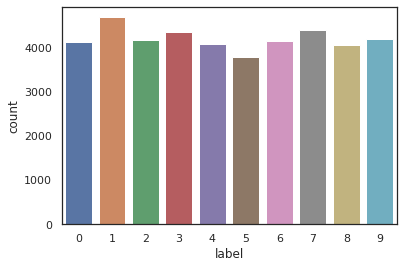

In [7]:
g = sns.countplot(Y_train)

Y_train.value_counts()

In [8]:
X_train.isnull().sum().unique()

array([0])

In [9]:
test.isnull().sum().unique()


array([0])

Normalize the data

In [10]:
# Normalize the data
X_train = X_train / 255.0
test = test / 255.0

In [11]:
# Reshape image in 3 dimensions (height = 28px, width = 28px , canal = 1)
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

In [12]:
# Encode labels to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
Y_train = to_categorical(Y_train, num_classes = 10)

In [13]:
# Split the train and the validation set for the fitting
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.3)

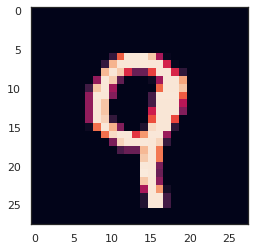

In [14]:
# Some examples
g = plt.imshow(X_train[0][:,:,0])

## Define the Model

In [15]:
# Set the CNN model 

model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))


In [16]:
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [17]:
# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [18]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [19]:
epochs = 60 
batch_size = 64

In [20]:
# With data augmentation to prevent overfitting

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=True,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip= True)  # randomly flip images


datagen.fit(X_train)

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:337: UserWarning: This ImageDataGenerator specifies `zca_whitening`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


In [21]:
# Fit the model
history = model.fit(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                               steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

Epoch 1/30
459/459 [==============================] - 42s 58ms/step - loss: 1.7153 - accuracy: 0.3926 - val_loss: 1.3367 - val_accuracy: 0.5468
Epoch 2/30
459/459 [==============================] - 26s 57ms/step - loss: 0.9319 - accuracy: 0.6754 - val_loss: 0.6180 - val_accuracy: 0.7898
Epoch 3/30
459/459 [==============================] - 26s 57ms/step - loss: 0.6891 - accuracy: 0.7664 - val_loss: 0.3498 - val_accuracy: 0.9028
Epoch 4/30
459/459 [==============================] - 27s 58ms/step - loss: 0.5371 - accuracy: 0.8256 - val_loss: 0.2546 - val_accuracy: 0.9250
Epoch 5/30
459/459 [==============================] - 27s 60ms/step - loss: 0.4601 - accuracy: 0.8502 - val_loss: 0.2482 - val_accuracy: 0.9284
Epoch 6/30
459/459 [==============================] - 27s 59ms/step - loss: 0.4191 - accuracy: 0.8689 - val_loss: 0.2001 - val_accuracy: 0.9371
Epoch 7/30
459/459 [==============================] - 27s 59ms/step - loss: 0.4022 - accuracy: 0.8710 - val_loss: 0.2399 - val_accuracy:

In [22]:
# predict results
results = model.predict(test)

# select the indix with the maximum probability
results = np.argmax(results,axis = 1)

results = pd.Series(results,name="Label")

# Submission

In [ ]:
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)

submission.to_csv("submission.csv",index=False)

In [ ]:
! kaggle competitions submit -c digit-recognizer -f submission.csv -m "Message"